# Part 4: Logging with Weights & Biases (20 pts)

This notebook logs the experiment and results to Weights & Biases for tracking and comparison.

**Tasks:**
1. Login to wandb
2. Initialize a new wandb run
3. Log hyperparameters (guidance weight, timesteps, etc.)
4. Log evaluation metrics (CLIP Score and FID)
5. Create a wandb.Table with all results
6. Finish the run

## Setup for Google Colab

Run this cell first to set up the environment for Google Colab or local execution.

In [ ]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    # Mount Google Drive to access data and save results
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up project directory
    PROJECT_DIR = '/content/drive/MyDrive/ahocv/Lab_3'
    import os
    os.chdir(PROJECT_DIR)
    print(f"Working directory: {PROJECT_DIR}")
else:
    print("Running locally")
    PROJECT_DIR = './'

# Install required packages
%pip install -q wandb matplotlib

🔗 Running in Google Colab!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Working directory: /content/drive/MyDrive/ahocv/Lab_3


In [16]:
# Import libraries
import sys
import os
import wandb
import numpy as np
from PIL import Image

# Ensure output directory exists
os.makedirs('generated_images', exist_ok=True)

In [17]:
# Load all analysis results from Part 3
analysis_results = np.load('fiftyone_analysis_results.npy', allow_pickle=True).item()

print("Loaded analysis results:")
print(f"  Prompts: {len(analysis_results['prompts'])}")
print(f"  CLIP Scores: {analysis_results['clip_scores']}")
print(f"  Uniqueness Scores: {analysis_results['uniqueness_scores']}")
print(f"  Representativeness Scores: {analysis_results['representativeness_scores']}")
print(f"  FID Score: {analysis_results['fid_score']:.4f}")

Loaded analysis results:
  Prompts: 10
  CLIP Scores: [0.22660394 0.1855945  0.23342869 0.16466743 0.17955676 0.19742665
 0.25665057 0.17178226 0.13571911 0.19435871]
  Uniqueness Scores: [0.989182972071377, 0.8420988516564625, 1.0, 0.9075398617756599, 0.995356400180776, 0.9334745036944098, 0.8164620349357716, 0.9040756797620552, 0.7800884445976232, 0.9896569706289816]
  Representativeness Scores: [0.8523152622457956, 0.87321316922842, 0.9055350754879614, 0.4515982873573018, 0.794404165286588, 0.46094893310209084, 1.0, 0.8037978777722807, 0.0, 0.7163117374417699]
  FID Score: 347.7909


In [18]:
# Login to wandb
# This will prompt for API key if not already logged in
wandb.login()

True

In [19]:
# Define hyperparameters used in the experiment
hyperparameters = {
    # Model architecture
    "model_type": "U-Net",
    "T": 400,  # Number of diffusion timesteps
    "img_channels": 3,
    "img_size": 32,
    "down_channels": "(256, 256, 512)",
    "t_embed_dim": 8,  # Time embedding dimension
    "c_embed_dim": 512,  # CLIP conditioning embedding dimension

    # DDPM parameters
    "B_start": 0.0001,
    "B_end": 0.02,

    # Training parameters
    "num_epochs": 5,  # Note: Should be 100 for full training
    "learning_rate": 0.001,
    "batch_size": 64,

    # Generation parameters
    "guidance_weight_w": 2.0,  # Classifier-free guidance weight
    "num_generated_images": 10,

    # CLIP model
    "clip_model": "ViT-B/32",
    "clip_features": 512,
}

print("Hyperparameters:")
for key, value in hyperparameters.items():
    print(f"  {key}: {value}")

Hyperparameters:
  model_type: U-Net
  T: 400
  img_channels: 3
  img_size: 32
  down_channels: (256, 256, 512)
  t_embed_dim: 8
  c_embed_dim: 512
  B_start: 0.0001
  B_end: 0.02
  num_epochs: 5
  learning_rate: 0.001
  batch_size: 64
  guidance_weight_w: 2.0
  num_generated_images: 10
  clip_model: ViT-B/32
  clip_features: 512


In [ ]:
# Initialize a new wandb run
# Using the same project as training for unified tracking
run = wandb.init(
    project="denoising_probabilistic_diffusion_models",  # Same project as Part 1 training
    name="evaluation_results",
    config=hyperparameters,
    tags=["evaluation", "diffusion", "flowers", "clip-guided", "assessment"],
    job_type="evaluation"  # Distinguish from training runs
)

print(f"Initialized wandb run: {run.name}")
print(f"Run URL: {run.url}")

🚀 Initialized wandb run: evaluation_results
📊 Run URL: https://wandb.ai/finnfreiheit/denoising_probabilistic_diffusion_models/runs/maoaj6vj


In [21]:
# Log evaluation metrics
metrics = {
    "fid_score": analysis_results['fid_score'],
    "mean_clip_score": analysis_results['mean_clip'],
    "mean_uniqueness": analysis_results['mean_uniqueness'],
    "mean_representativeness": analysis_results['mean_representativeness'],
    "std_clip_score": float(np.std(analysis_results['clip_scores'])),
    "min_clip_score": float(np.min(analysis_results['clip_scores'])),
    "max_clip_score": float(np.max(analysis_results['clip_scores'])),
}

wandb.log(metrics)

print("Logged metrics:")
for key, value in metrics.items():
    print(f"  {key}: {value:.4f}")

Logged metrics:
  fid_score: 347.7909
  mean_clip_score: 0.1946
  mean_uniqueness: 0.9158
  mean_representativeness: 0.6858
  std_clip_score: 0.0340
  min_clip_score: 0.1357
  max_clip_score: 0.2567


In [22]:
# Create a wandb.Table with all results
# The table includes: generated image, text prompt, CLIP score, uniqueness score, representativeness score

columns = [
    "Image",
    "Prompt",
    "CLIP Score",
    "Uniqueness",
    "Representativeness"
]

data = []

for i, (prompt, img_path, clip_score, uniq, rep) in enumerate(zip(
    analysis_results['prompts'],
    analysis_results['image_paths'],
    analysis_results['clip_scores'],
    analysis_results['uniqueness_scores'],
    analysis_results['representativeness_scores']
)):
    # Load image for wandb
    abs_path = os.path.abspath(img_path)
    img = Image.open(abs_path)
    wandb_image = wandb.Image(img, caption=prompt[:50])

    data.append([
        wandb_image,
        prompt,
        float(clip_score),
        float(uniq),
        float(rep)
    ])

    print(f"Added sample {i+1}: {prompt[:30]}...")

# Create and log the table
results_table = wandb.Table(columns=columns, data=data)
wandb.log({"generated_images_results": results_table})

print(f"\nLogged results table with {len(data)} samples")

Added sample 1: A photo of a red rose...
Added sample 2: A photo of a white daisy...
Added sample 3: A photo of a yellow sunflower...
Added sample 4: A beautiful pink rose with gre...
Added sample 5: A bright orange sunflower in s...
Added sample 6: A white daisy with yellow cent...
Added sample 7: A red rose bud...
Added sample 8: A field of sunflowers...
Added sample 9: A bouquet of daisies...
Added sample 10: A single red rose on a stem...

Logged results table with 10 samples


In [23]:
# Log individual images with their metrics
for i, (prompt, img_path, clip_score) in enumerate(zip(
    analysis_results['prompts'],
    analysis_results['image_paths'],
    analysis_results['clip_scores']
)):
    abs_path = os.path.abspath(img_path)
    img = Image.open(abs_path)

    wandb.log({
        f"generated_image_{i}": wandb.Image(img, caption=f"{prompt} (CLIP: {clip_score:.3f})")
    })

print(f"Logged {len(analysis_results['prompts'])} individual images")

Logged 10 individual images


In [24]:
# Log visualization images
viz_paths = [
    'generated_images/evaluation_results.png',
    'generated_images/fiftyone_analysis.png',
    'generated_images/score_comparison.png'
]

for viz_path in viz_paths:
    if os.path.exists(viz_path):
        viz_name = os.path.basename(viz_path).replace('.png', '')
        wandb.log({viz_name: wandb.Image(viz_path)})
        print(f"Logged visualization: {viz_name}")

Logged visualization: evaluation_results
Logged visualization: fiftyone_analysis
Logged visualization: score_comparison


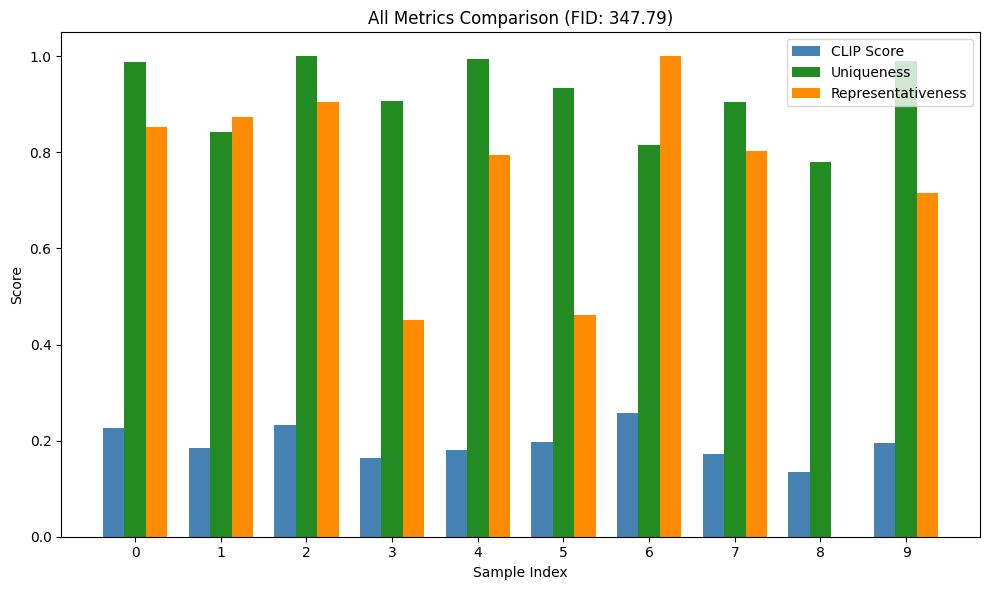

Logged summary chart to wandb


In [25]:
# Create a summary bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(analysis_results['prompts']))
width = 0.25

bars1 = ax.bar([i - width for i in x], analysis_results['clip_scores'], width, label='CLIP Score', color='steelblue')
bars2 = ax.bar(x, analysis_results['uniqueness_scores'], width, label='Uniqueness', color='forestgreen')
bars3 = ax.bar([i + width for i in x], analysis_results['representativeness_scores'], width, label='Representativeness', color='darkorange')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Score')
ax.set_title(f'All Metrics Comparison (FID: {analysis_results["fid_score"]:.2f})')
ax.set_xticks(x)
ax.legend()

plt.tight_layout()
plt.savefig('generated_images/wandb_summary.png', dpi=150)
plt.show()

# Log to wandb
wandb.log({"metrics_summary_chart": wandb.Image('generated_images/wandb_summary.png')})
print("Logged summary chart to wandb")

In [26]:
# Log a summary of the experiment
wandb.summary.update({
    "total_images_generated": len(analysis_results['prompts']),
    "best_clip_score": float(np.max(analysis_results['clip_scores'])),
    "best_clip_prompt": analysis_results['prompts'][np.argmax(analysis_results['clip_scores'])],
    "most_unique_prompt": analysis_results['prompts'][np.argmax(analysis_results['uniqueness_scores'])],
    "most_representative_prompt": analysis_results['prompts'][np.argmax(analysis_results['representativeness_scores'])],
})

print("Updated wandb summary with best results")

Updated wandb summary with best results


In [ ]:
# Display final summary
print("=" * 60)
print("PART 4 SUMMARY - Weights & Biases Logging")
print("=" * 60)
print(f"\nProject: diffusion_model_assessment_v2")
print(f"Run Name: {run.name}")
print(f"Run ID: {run.id}")
print(f"Run URL: {run.url}")
print("\nLogged Items:")
print("  - Hyperparameters (model architecture, training params)")
print("  - Evaluation metrics (FID, CLIP scores)")
print("  - Results table with images, prompts, and all scores")
print("  - Individual generated images")
print("  - Visualization charts")
print("  - Summary statistics")
print("\nMetrics Summary:")
print(f"  FID Score: {analysis_results['fid_score']:.4f}")
print(f"  Mean CLIP Score: {analysis_results['mean_clip']:.4f}")
print(f"  Mean Uniqueness: {analysis_results['mean_uniqueness']:.4f}")
print(f"  Mean Representativeness: {analysis_results['mean_representativeness']:.4f}")
print("=" * 60)

PART 4 SUMMARY - Weights & Biases Logging

Project: diffusion_model_assessment_v2
Run Name: evaluation_results
Run ID: maoaj6vj
Run URL: https://wandb.ai/finnfreiheit/denoising_probabilistic_diffusion_models/runs/maoaj6vj

Logged Items:
  ✓ Hyperparameters (model architecture, training params)
  ✓ Evaluation metrics (FID, CLIP scores)
  ✓ Results table with images, prompts, and all scores
  ✓ Individual generated images
  ✓ Visualization charts
  ✓ Summary statistics

Metrics Summary:
  FID Score: 347.7909
  Mean CLIP Score: 0.1946
  Mean Uniqueness: 0.9158
  Mean Representativeness: 0.6858


In [ ]:
# Finish the wandb run
run.finish()
print("\nWandb run finished successfully")
print(f"View your results at: {run.url}")

fid_score,▁
max_clip_score,▁
mean_clip_score,▁
mean_representativeness,▁
mean_uniqueness,▁
min_clip_score,▁
std_clip_score,▁
best_clip_prompt,A red rose bud
best_clip_score,0.25665
fid_score,347.79086
max_clip_score,0.25665



✓ Wandb run finished successfully!
View your results at: https://wandb.ai/finnfreiheit/denoising_probabilistic_diffusion_models/runs/maoaj6vj


## Summary

Part 4 completed successfully. We have:

1. Set up Google Colab compatibility (auto-mounts Drive)
2. Logged in to Weights & Biases
3. Initialized a new wandb run with project "diffusion-flowers-training" (same as training)
4. Logged hyperparameters (guidance weight w, timesteps T, model architecture)
5. Logged evaluation metrics (CLIP Score and FID)
6. Created a wandb.Table with:
   - Generated images
   - Text prompts
   - CLIP scores
   - Uniqueness scores
   - Representativeness scores
7. Finished the wandb run

All experiment results are now tracked and can be compared with training runs.